In [1]:
import keras 
from utils import get_data, serialize_data, next_batch, breed_overview
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
print tf.__version__

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

1.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3450698250502759319
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1522401280
locality {
  bus_id: 1
}
incarnation: 6901243706269817529
physical_device_desc: "device: 0, name: Quadro M1000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


### Set parameters

In [3]:
root_dir = "/home/anne/src/dog_identification/"  
train_zip = root_dir + "data/train.zip"
valid_zip = root_dir + "data/valid.zip"
training_filename = root_dir + "data/train.p"
validation_filename = root_dir + "data/valid.p"
labels_filename = root_dir + "data/labels.csv.zip"

num_validation = 0.3
batch_size = 100
n_batches = 50

n_breeds = 20

nwidth = 80
nheight = 80

### Inspect the data

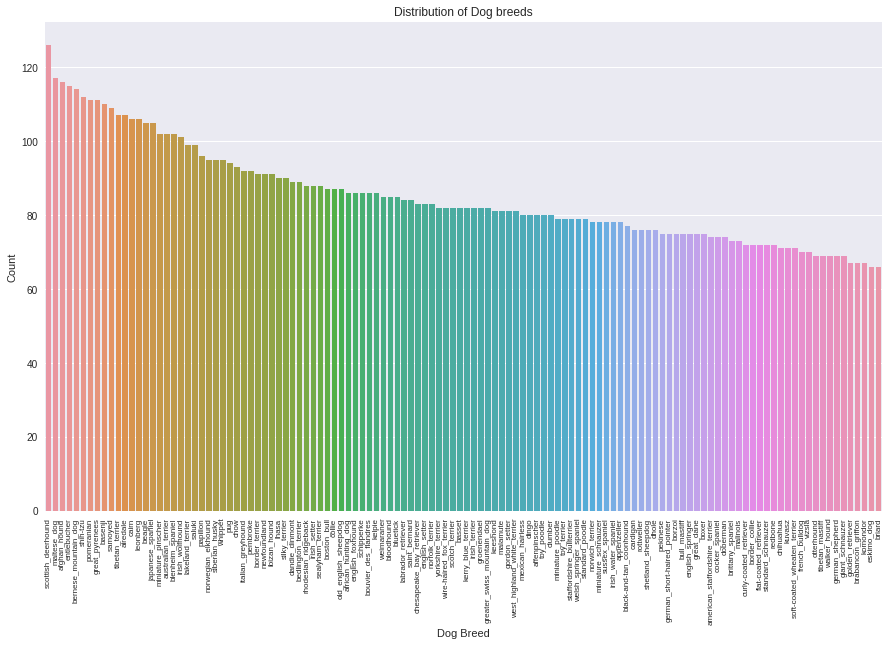

In [3]:
breed_overview(labels_filename)

### Process the data

In [4]:
# Load the whole dataset into memory
serialize_data(train_zip, labels_filename, training_filename, img_size=nwidth)
x, y, breed_dict = get_data(training_filename, labels_filename, top_breeds=n_breeds)

Creating serialized file format for /home/anne/src/dog_identification/data/train.zip
pickle file already exists, continueing
Loading pickle file /home/anne/src/dog_identification/data/train.p


In [5]:
y_hot = keras.utils.to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y_hot, test_size=num_validation, random_state=6)

# Eval train test sets
unique_train, freq_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
unique_val, freq_val = np.unique(np.argmax(y_val, axis=1), return_counts=True)

# Make sure every breed is included in both sets
assert (unique_train.shape[0]==unique_val.shape[0]), "Missing breeds in train/val sets"

print("Label frequency training set: max=%d, min=%d" % (np.amax(freq_train), np.amin(freq_train)))
print("Label frequency validation set: max=%d, min=%d" % (np.amax(freq_val), np.amin(freq_val)))

nb_train_samples = x_train.shape[0]
nb_val_samples = x_val.shape[0]

Label frequency training set: max=86, min=68
Label frequency validation set: max=40, min=26


### Create data flow objects

In [6]:
train_gen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.1,
        channel_shift_range=0.1,
        horizontal_flip=True)
train_gen.fit(x_train)
train_flow = train_gen.flow(x_train, y_train, batch_size=batch_size)

val_gen = ImageDataGenerator()
val_gen.fit(x_val)
val_flow =val_gen.flow(x_val, y_val, batch_size=batch_size)

### Define the model

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(nwidth, nheight,3), data_format='channels_last'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))

# model.add(Conv2D(256, (3, 3)))
# model.add(Activation('relu'))
# model.add(Conv2D(256, (3, 3)))

model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Flatten())
model.add(Dense(2000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_breeds, activation='softmax'))

print("Compiling model")
model.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(),
          metrics=['accuracy'])

model.summary()

Compiling model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 76, 76, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 76, 76, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 36, 64)        18496     
_________________________________________________________________
activation_10 (Activation)   (None, 36, 36, 64)        0    

### Train the model

In [10]:
epochs = 1000

print("Starting generator")
hist = model.fit_generator(
        train_flow,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=val_flow,
        validation_steps=nb_val_samples // batch_size)

Starting generator
Epoch 1/1000
15/15 [==============================] - 5s 358ms/step - loss: 3.0023 - acc: 0.0448 - val_loss: 2.9914 - val_acc: 0.0633
Epoch 2/1000
15/15 [==============================] - 5s 327ms/step - loss: 2.9935 - acc: 0.0578 - val_loss: 2.9859 - val_acc: 0.0967
Epoch 3/1000
15/15 [==============================] - 5s 317ms/step - loss: 2.9645 - acc: 0.0744 - val_loss: 2.9927 - val_acc: 0.0683
Epoch 4/1000
15/15 [==============================] - 5s 318ms/step - loss: 2.9648 - acc: 0.0684 - val_loss: 2.9475 - val_acc: 0.0717
Epoch 5/1000
15/15 [==============================] - 5s 357ms/step - loss: 2.9147 - acc: 0.0867 - val_loss: 2.8623 - val_acc: 0.1067
Epoch 6/1000
15/15 [==============================] - 5s 318ms/step - loss: 2.9205 - acc: 0.0891 - val_loss: 2.8772 - val_acc: 0.1183
Epoch 7/1000
15/15 [==============================] - 5s 309ms/step - loss: 2.8550 - acc: 0.1113 - val_loss: 2.8342 - val_acc: 0.1133
Epoch 8/1000
15/15 [=======================

15/15 [==============================] - 5s 320ms/step - loss: 1.2054 - acc: 0.6084 - val_loss: 2.0224 - val_acc: 0.3833
Epoch 122/1000
15/15 [==============================] - 5s 341ms/step - loss: 1.1948 - acc: 0.6067 - val_loss: 1.9993 - val_acc: 0.3750
Epoch 123/1000
15/15 [==============================] - 5s 323ms/step - loss: 1.2666 - acc: 0.5773 - val_loss: 1.9652 - val_acc: 0.3983
Epoch 124/1000
15/15 [==============================] - 5s 309ms/step - loss: 1.2101 - acc: 0.6104 - val_loss: 1.9247 - val_acc: 0.3983
Epoch 125/1000
15/15 [==============================] - 5s 340ms/step - loss: 1.2229 - acc: 0.6020 - val_loss: 1.9497 - val_acc: 0.4133
Epoch 126/1000
15/15 [==============================] - 5s 324ms/step - loss: 1.1870 - acc: 0.6142 - val_loss: 1.9209 - val_acc: 0.4033
Epoch 127/1000
15/15 [==============================] - 5s 322ms/step - loss: 1.1468 - acc: 0.6178 - val_loss: 1.9975 - val_acc: 0.3867
Epoch 128/1000
15/15 [==============================] - 5s 324m

15/15 [==============================] - 5s 324ms/step - loss: 0.5476 - acc: 0.8276 - val_loss: 2.0619 - val_acc: 0.4367
Epoch 242/1000
15/15 [==============================] - 5s 330ms/step - loss: 0.5123 - acc: 0.8351 - val_loss: 2.1378 - val_acc: 0.4450
Epoch 243/1000
15/15 [==============================] - 5s 310ms/step - loss: 0.4850 - acc: 0.8411 - val_loss: 2.3268 - val_acc: 0.4300
Epoch 244/1000
15/15 [==============================] - 6s 384ms/step - loss: 0.6085 - acc: 0.8091 - val_loss: 2.2790 - val_acc: 0.4183
Epoch 245/1000
15/15 [==============================] - 5s 356ms/step - loss: 0.5803 - acc: 0.8158 - val_loss: 2.1354 - val_acc: 0.4617
Epoch 246/1000
15/15 [==============================] - 5s 304ms/step - loss: 0.5038 - acc: 0.8388 - val_loss: 2.1389 - val_acc: 0.4433
Epoch 247/1000
15/15 [==============================] - 5s 328ms/step - loss: 0.5275 - acc: 0.8254 - val_loss: 2.1674 - val_acc: 0.4500
Epoch 248/1000
15/15 [==============================] - 5s 337m

15/15 [==============================] - 5s 342ms/step - loss: 0.3359 - acc: 0.8873 - val_loss: 2.2286 - val_acc: 0.4650
Epoch 362/1000
15/15 [==============================] - 5s 336ms/step - loss: 0.3220 - acc: 0.9053 - val_loss: 2.4098 - val_acc: 0.4533
Epoch 363/1000
15/15 [==============================] - 5s 317ms/step - loss: 0.3174 - acc: 0.8872 - val_loss: 2.4346 - val_acc: 0.4467
Epoch 364/1000
15/15 [==============================] - 5s 329ms/step - loss: 0.4002 - acc: 0.8720 - val_loss: 2.4276 - val_acc: 0.4717
Epoch 365/1000
15/15 [==============================] - 5s 342ms/step - loss: 0.3321 - acc: 0.8913 - val_loss: 2.3776 - val_acc: 0.4600
Epoch 366/1000
15/15 [==============================] - 5s 329ms/step - loss: 0.3318 - acc: 0.8933 - val_loss: 2.3121 - val_acc: 0.4783
Epoch 367/1000
15/15 [==============================] - 5s 329ms/step - loss: 0.3720 - acc: 0.8787 - val_loss: 2.4621 - val_acc: 0.4567
Epoch 368/1000
15/15 [==============================] - 5s 328m

15/15 [==============================] - 5s 301ms/step - loss: 0.2502 - acc: 0.9180 - val_loss: 2.7038 - val_acc: 0.4567
Epoch 482/1000
15/15 [==============================] - 5s 302ms/step - loss: 0.2392 - acc: 0.9215 - val_loss: 2.5030 - val_acc: 0.4600
Epoch 483/1000
15/15 [==============================] - 5s 313ms/step - loss: 0.2698 - acc: 0.9180 - val_loss: 2.6047 - val_acc: 0.4617
Epoch 484/1000
15/15 [==============================] - 4s 289ms/step - loss: 0.2963 - acc: 0.8996 - val_loss: 2.4903 - val_acc: 0.4750
Epoch 485/1000
15/15 [==============================] - 5s 301ms/step - loss: 0.2628 - acc: 0.9145 - val_loss: 2.6645 - val_acc: 0.4700
Epoch 486/1000
15/15 [==============================] - 5s 338ms/step - loss: 0.2941 - acc: 0.9120 - val_loss: 2.4949 - val_acc: 0.4667
Epoch 487/1000
15/15 [==============================] - 5s 340ms/step - loss: 0.2814 - acc: 0.9094 - val_loss: 2.3586 - val_acc: 0.4767
Epoch 488/1000
15/15 [==============================] - 5s 316m

15/15 [==============================] - 5s 342ms/step - loss: 0.2237 - acc: 0.9228 - val_loss: 2.5633 - val_acc: 0.4750
Epoch 602/1000
15/15 [==============================] - 5s 320ms/step - loss: 0.2073 - acc: 0.9367 - val_loss: 2.5407 - val_acc: 0.4817
Epoch 603/1000
15/15 [==============================] - 5s 325ms/step - loss: 0.1855 - acc: 0.9409 - val_loss: 2.7632 - val_acc: 0.4833
Epoch 604/1000
15/15 [==============================] - 5s 313ms/step - loss: 0.2515 - acc: 0.9243 - val_loss: 2.5187 - val_acc: 0.4900
Epoch 605/1000
15/15 [==============================] - 5s 324ms/step - loss: 0.2131 - acc: 0.9353 - val_loss: 2.5572 - val_acc: 0.4833
Epoch 606/1000
15/15 [==============================] - 5s 312ms/step - loss: 0.2188 - acc: 0.9385 - val_loss: 2.5711 - val_acc: 0.4667
Epoch 607/1000
15/15 [==============================] - 5s 315ms/step - loss: 0.2197 - acc: 0.9310 - val_loss: 2.5575 - val_acc: 0.4767
Epoch 608/1000
15/15 [==============================] - 5s 307m

15/15 [==============================] - 5s 312ms/step - loss: 0.1679 - acc: 0.9500 - val_loss: 2.8641 - val_acc: 0.4783
Epoch 722/1000
15/15 [==============================] - 4s 299ms/step - loss: 0.1843 - acc: 0.9442 - val_loss: 2.8569 - val_acc: 0.4817
Epoch 723/1000
15/15 [==============================] - 5s 300ms/step - loss: 0.1520 - acc: 0.9489 - val_loss: 2.8436 - val_acc: 0.4800
Epoch 724/1000
15/15 [==============================] - 5s 300ms/step - loss: 0.1785 - acc: 0.9453 - val_loss: 2.8677 - val_acc: 0.4567
Epoch 725/1000
15/15 [==============================] - 5s 322ms/step - loss: 0.2014 - acc: 0.9353 - val_loss: 2.7698 - val_acc: 0.4817
Epoch 726/1000
15/15 [==============================] - 5s 330ms/step - loss: 0.1852 - acc: 0.9393 - val_loss: 2.7993 - val_acc: 0.4550
Epoch 727/1000
15/15 [==============================] - 5s 332ms/step - loss: 0.1834 - acc: 0.9466 - val_loss: 2.8228 - val_acc: 0.4717
Epoch 728/1000
15/15 [==============================] - 5s 331m

15/15 [==============================] - 5s 318ms/step - loss: 0.1524 - acc: 0.9487 - val_loss: 2.9218 - val_acc: 0.4833
Epoch 842/1000
15/15 [==============================] - 4s 290ms/step - loss: 0.1297 - acc: 0.9585 - val_loss: 2.8974 - val_acc: 0.4817
Epoch 843/1000
15/15 [==============================] - 5s 304ms/step - loss: 0.2141 - acc: 0.9370 - val_loss: 2.8177 - val_acc: 0.4750
Epoch 844/1000
15/15 [==============================] - 5s 320ms/step - loss: 0.2129 - acc: 0.9400 - val_loss: 2.9661 - val_acc: 0.4683
Epoch 845/1000
15/15 [==============================] - 4s 293ms/step - loss: 0.1741 - acc: 0.9518 - val_loss: 2.7418 - val_acc: 0.4750
Epoch 846/1000
15/15 [==============================] - 5s 317ms/step - loss: 0.1917 - acc: 0.9453 - val_loss: 2.6201 - val_acc: 0.4767
Epoch 847/1000
15/15 [==============================] - 5s 316ms/step - loss: 0.1943 - acc: 0.9391 - val_loss: 2.8206 - val_acc: 0.4633
Epoch 848/1000
15/15 [==============================] - 5s 308m

15/15 [==============================] - 5s 312ms/step - loss: 0.1815 - acc: 0.9426 - val_loss: 2.7164 - val_acc: 0.4683
Epoch 962/1000
15/15 [==============================] - 5s 310ms/step - loss: 0.1773 - acc: 0.9456 - val_loss: 2.7509 - val_acc: 0.4800
Epoch 963/1000
15/15 [==============================] - 5s 314ms/step - loss: 0.1538 - acc: 0.9549 - val_loss: 2.9165 - val_acc: 0.4933
Epoch 964/1000
15/15 [==============================] - 5s 328ms/step - loss: 0.1484 - acc: 0.9533 - val_loss: 2.8029 - val_acc: 0.4867
Epoch 965/1000
15/15 [==============================] - 4s 295ms/step - loss: 0.1480 - acc: 0.9617 - val_loss: 2.7617 - val_acc: 0.4933
Epoch 966/1000
15/15 [==============================] - 5s 318ms/step - loss: 0.1455 - acc: 0.9513 - val_loss: 2.6787 - val_acc: 0.5000
Epoch 967/1000
15/15 [==============================] - 4s 290ms/step - loss: 0.1397 - acc: 0.9552 - val_loss: 2.7944 - val_acc: 0.4867
Epoch 968/1000
15/15 [==============================] - 5s 301m

### Evaluate training

['acc', 'loss', 'val_acc', 'val_loss']


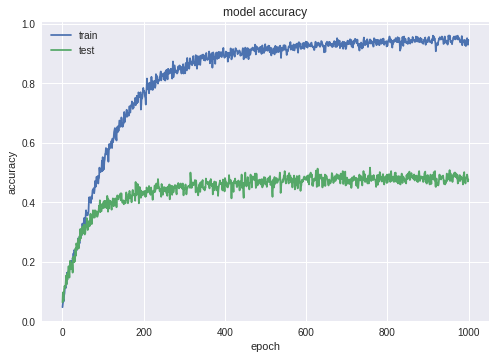

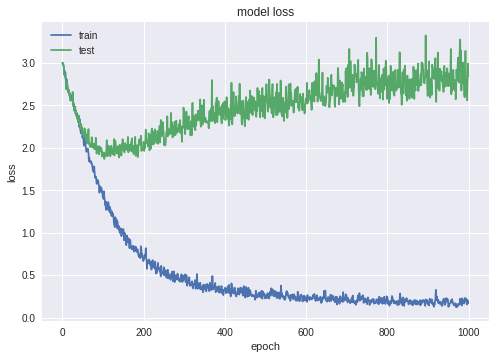

In [11]:
print(hist.history.keys())

# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(100, 78, 78, 32)


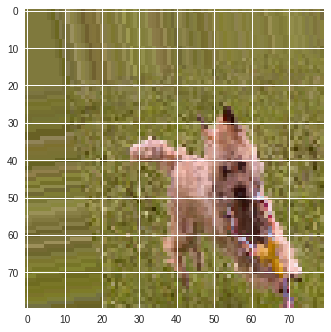

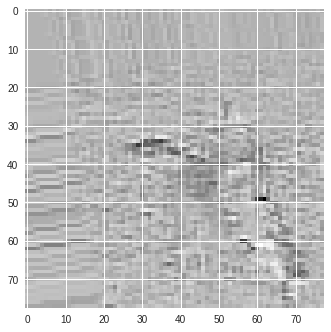

(100, 76, 76, 32)


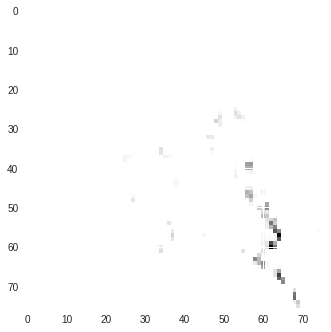

In [12]:
x_test, y_test = train_flow.next()


from keras import backend as K
conv0 = K.function([model.layers[0].input], [model.layers[0].output])
out0=conv0([x_test])[0]
print out0.shape

plt.imshow(x_test[0,:,:,:])
plt.show()
plt.imshow(out0[0,:,:,0])
plt.show()
# plt.imshow(out0[0,:,:,31])
# plt.show()


pool0 = K.function([model.layers[0].input], [model.layers[3].output])
out1=pool0([x_test])[0]
print out1.shape
plt.imshow(out1[0,:,:,0])
plt.show()